# Markov Decision Process

Parts of this notebook has been reproduced from the [Hands-On Machine Learning with Scikit-Learn and TensorFlow](https://www.amazon.co.uk/Hands-Machine-Learning-Scikit-Learn-TensorFlow/dp/1491962291) book.

In this process an agent learns to estimate the expected sum of discounted future rewards for each state, or the expected sum of discounted future rewards for each action in each state, then uses this knowledge to decide how to act.

Stochastic Process:
- Fixed number of states
- Randomly evolves from one state to another at each step
- Probability to evolve from a state $s$ to a state $s'$ is fixed and depends on only on the pair $(s, s')$, not on past states


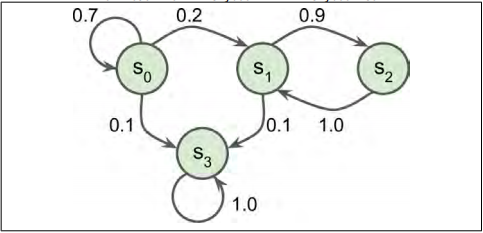
**Image taken from: Hands-on Machine Learning with Scikit-Learn & Tensorflow - A. Geron**


The above image is an example of a Markov chain with 4 states. If the process starts at $s_0$ there is 70% chance it will remain in the same state at the next step. Once it leaves the state it will never come back because there are no other states that return to $s_0$. If it goes to $s_1$ it will them most likely go to state $s_2$ (probability is 90%) and then immediately back to state $s_1$. There is also the possibility it may alternate between these two states, but it will eventually fall back so $s_3$ and remain there forever. $s_3$ is a terminal state because once it's in this state it cannot leave.

Let's run through the above example with some code:

In [1]:
import numpy as np

In [2]:
"""
The transition probability matrix taken from the image above.
Each row represents a state
Each columns represents the probability of transitioning to a state. 
The column indexes represents the state number,
"""
transition_probabilities = np.array([
    [0.7, 0.2, 0.0, 0.1],  # s0 to s0, s1, s2, s3
    [0.0, 0.0, 0.9, 0.1],  # s1 to ...
    [0.0, 1.0, 0.0, 0.0],  # s2 to ...
    [0.0, 0.0, 0.0, 1.0],  # s3 to ...
])

max_transitions = 20
n_runs = 10
start_state = 0

for _ in range(n_runs):
    current_state = start_state
    transitions = []
    for step in range(max_transitions):
        if current_state == 3: # When reaching state 3 it can't leave, so break out
            break
        current_state = np.random.choice( # Choose 1 of the 4 states to transition to
            np.arange(4), # Create array of 4 states
            p=transition_probabilities[current_state] # Supply the associated transition probability given the current state
        )
        transitions.append(str(current_state))
    else:
        transitions.append('...')
    print('States:',' '.join(transitions))

States: 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 ...
States: 0 0 0 0 0 3
States: 0 0 0 1 2 1 2 1 3
States: 1 3
States: 0 0 0 1 2 1 2 1 3
States: 0 0 1 2 1 2 1 2 1 2 1 2 1 2 1 3
States: 0 0 3
States: 0 0 1 2 1 2 1 3
States: 0 0 0 0 0 0 0 1 2 1 2 1 2 1 2 1 2 1 2 1 ...
States: 0 0 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 ...


Fairly simple to implement. In the runs above the transitions most stay within state 0, or alternate between 1 and 2 which makes sense as these transitions have the highest probability.

Markov decision process (MDP) is slightly different to the Markov chain process. The transition to different states returns some reward (positive or negative), and the agent's goal is to find a policy that will maximise the rewards over time. An example of this is shown below:

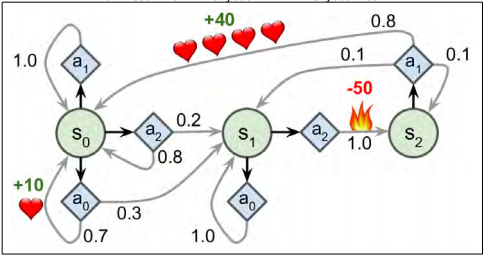
**Image taken from: Hands-on Machine Learning with Scikit-Learn & Tensorflow - A. Geron**

The MDP in the figure above has three states and up to three possible discrete actions at each step. The process starts at $s_0$, the agent can choose between actions $a_0$, $a_1$, $a_2$. If it chooses actions $a_1$, it just remains in state $s_0$ with certainty, and without and reward. It can thus decide to stay there forever. If action $a_0$ is chosen, it has 70% probability of gaining a reward of +10 and remaining in state $s_0$. It can then try again and again to gain as much reward as possible. But at one point it is going to end up in state $s_1$. In state $s_1$ it has only two possible actions $a_0$ and $a_2$. Eventually it will move onto state $s_2$ and get a negative reward of -50. In state $s_2$ it has no other choice but take action $a_1$, which will most likely lead it back to state $s_0$, gaining a reward of +40 along the way. Looking at this figure what is the best strategy to maximise the reward over time?

The optimal value of any state $s$, noted $V^*(s)$ can be estimated by taking the sum of all discounted future rewards the agent can expect on average after it reaches a state $s$, assuming it acts optimally. If the agent acts optimally, then the following (Bellman Optimality) equation applies. The equation is recursive and states that if the agent acts optimally, then the optimal value of the current state is equal to the reward it will get on average after taking one optimal action, plus the expected optimal value of all possible next states that this action can lead to.

\begin{equation}
V^*(s) = \mathop{max}_{\textbf{a}} \sum_{s'}T(s,a,s')[R(s,a,s')+\gamma.V^*(s')] \text{ for all s}
\end{equation}

- $V^*(s)$ - Optimal state value
- $T(s,a,s')$ - Transition probability from state $s$ to that state $s'$ given the agent chose action $a$
- $R(s,a,s')$ - Is the reward that the agent gets when it goes from state $s$ to state $s'$, giben the agent chose action $a$
- $\gamma$ - The discount rate

Equation leads to directly to an algorithm that can precisely estimate the optimal state value of every possible state:
- Initiate all state values to zero
- Iteratively update them using the value iteration algorithm (below)

\begin{equation}
V_{k+1}(s) \leftarrow \mathop{max}_{\textbf{a}} \sum_{s'}T(s,a,s')[R(s,a,s')+\gamma.V^*(s')] \text{ for all s}
\end{equation}

- $V_k(s)$ - estimated value of state $s$ at the $k^{th}$ iteration of the algorithm

Knowing the optimal state is useful but it doesn't tell the agent what to do. It is possible to find the optimal state using Q-value of a state-action pair $(s, a)$, noted $Q^*(s,a)$, is the sum of all the discounted future rewards that agent can expect on average after it reaches that state $s$ and chooses action $a$, but before it sees the outcome of this action, assuming it acts optimally. Below is the quation for the Q-value iteration algorithm.

\begin{equation}
Q_{k+1}(s,a) \leftarrow \sum_{s'}T(s,a,s')[R(s,a,s')+\gamma\text{ }.\text{ }\mathop{max}_{\textbf{a'}}\text{ }Q_k(s', a')] \text{ for all }(s,a)
\end{equation}

Once you have optimal Q-values, defining the optimal policy, notes $\pi^*(s)$, is trivial: when the agent is in state $s$, it should choose the action with the highest Q-value for that state:
\begin{equation}
\pi^*(s) = \mathop{argmax}_{\textbf{a}} Q^*(s,a)
\end{equation}

To gain a better understanding of the Q-value algorithm let's apply the algorithm to the MDP, using the example above starting by defining the transition, rewards and actions matrices

In [5]:
nan = np.nan # this is for impossible actions

# Shape = [s, a, s']
# First axis is state
# second axis are actions
# thrid axis are probs to transitions to state s'
# e.g. first row (transition_probs[0][0][0])
# is state s0 action a0 there is 70% chance of going back to state s0 (hence why it's at index 0)
transition_probs = np.array([
    [
        [0.7, 0.3, 0.0], # state s0 action a0
        [1.0, 0.0, 0.0], # state s0 action a1
        [0.8, 0.2, 0.0], # state s0 action a2
    ],
    [
        [0.0, 1.0, 0.0], # state s1 action a0
        [nan, nan, nan], # state s1 action a1 - does not exist hence all nan
        [0.0, 0.0, 1.0], # state s1 action a2
    ],
    [
        [nan, nan, nan], # state s2 action a0 - does not exist
        [0.8, 0.1, 0.1], # state s2 action a1
        [nan, nan, nan], # state s2 action a2
    ]
])

# Shape = [s, a, s']
rewards = np.array([
    [
        [10.0, 0.0, 0.0], # state s0 action a0
        [0.0, 0.0, 0.0], # state s0 action a1
        [0.0, 0.0, 0.0], # state s0 action a2
    ],
    [
        [0.0, 0.0, 0.0], # state s1 action a0
        [nan, nan, nan], # state s1 action a1 - does not exist hence all nan
        [0.0, 0.0, -50.0], # state s1 action a2
    ],
    [
        [nan, nan, nan], # state s2 action a0 - does not exist
        [40.0, 0.0, 0.0], # state s2 action a1
        [nan, nan, nan], # state s2 action a2
    ]
])

# Defines the possible actions for a given state
actions = np.array([
    [0, 1, 2], # State s0 actions
    [0, 2], # State s1 actions
    [1], # State s2 actions
])

In [3]:
transition_probs.shape

(3, 3, 3)

In [4]:
rewards.shape

(3, 3, 3)

In [5]:
# state 0, rows are actions and columns are states (s')
transition_probs[0]

array([[0.7, 0.3, 0. ],
       [1. , 0. , 0. ],
       [0.8, 0.2, 0. ]])

In [6]:
# state 0
rewards[0]

array([[10.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.]])

With everything setup let's create the MDP environment class and a method to run the episode:

In [3]:
class MDPEnv:
    
    def __init__(self, start_state: int=0):
        self.start_state = start_state
        self.state = self.start_state
        self.total_rewards = 0
        
    def reset_env(self,):
        """ Reset the environment """
        self.state = self.start_state
        self.total_rewards = 0
        
    def step(self, action: int):
        """ Take a step with the selected action """
        next_state = np.random.choice(
            np.arange(3), # 3 states
            p=transition_probs[self.state][action] # apply the transition probability given the current state and action
        )
        reward = rewards[self.state][action][next_state]
        self.state = next_state
        self.total_rewards += reward
        return self.state, reward
    
def run_episode(policy, n_steps, start_state=0, verbose=False):
    env = MDPEnv(start_state=start_state)
    
    transitions = [str(env.start_state)]
    for step in range(n_steps):
        action = policy(env.state)
        state, reward = env.step(action)
        transitions.append(f'{state} ({reward})')
    if verbose:
        print(' -> '.join(transitions))
    return env.total_rewards

With the MDP setup let's create a random policy to generate some actions for us:

In [23]:
def random_action_policy(state):
    """ Randomly selects an action given the state """
    return np.random.choice(actions[state])

random_action_policy(1)

2

In [24]:
run_episode(random_action_policy, 10, verbose=True)

0 -> 0 (0.0) -> 0 (10.0) -> 0 (0.0) -> 0 (0.0) -> 1 (0.0) -> 2 (-50.0) -> 1 (0.0) -> 2 (-50.0) -> 0 (40.0) -> 0 (10.0)


-40.0

In the above example we have a single run with 10 steps. The arrow indicates a transition to the next state with the reward of this transition in brackets. The `run_episode` method also returns the total reward for this run. So it looks like we have a random policy working! Let's create a futher two policies:
- `policy_action_fire`: Will optimise going down the fire path
- `policy_action_safe`: Will optimise for playing it 'safe' and avoiding the fire path

In [25]:
def policy_action_fire(state: int):
    """
    Returns the action for a given state.
    
    If state is 0 perfrom action 0
    If state is 1 perfrom action 2
    if state is 2 perform action 1
    """
    return [0, 2, 1][state]

def policy_action_safe(state: int):
    """
    Returns the 'safe' action given the state
    
    If state is 0 perform action 0
    If state is 1 perfrom action 0
    If state is 2 perfrom action 1
    """
    return [0, 0, 1][state]

Let's run each of the new policy once and see what it returns:

In [29]:
run_episode(policy_action_fire, 10, verbose=True)

0 -> 0 (10.0) -> 0 (10.0) -> 0 (10.0) -> 0 (10.0) -> 1 (0.0) -> 2 (-50.0) -> 0 (40.0) -> 1 (0.0) -> 2 (-50.0) -> 0 (40.0)


20.0

In [31]:
run_episode(policy_action_safe, 10, verbose=True)

0 -> 0 (10.0) -> 0 (10.0) -> 1 (0.0) -> 1 (0.0) -> 1 (0.0) -> 1 (0.0) -> 1 (0.0) -> 1 (0.0) -> 1 (0.0) -> 1 (0.0)


20.0

You can see with the `policy_action_fire` policy it always chooses the fire path to obtain the +40 reward although it also obtains the -50 reward for transitioning from state 1 to state 2.

The `policy_action_safe` policy completely avoids the fire path. It attemtps to obtain rewards by staying in state 0 by choosing action 0 but there is a 30% chance when choosing this action to transition to state 1. If it reaches state 1 it always chooses action 0 where is has 100% probability of statying in state 1, thus completely avoiding the fire path.

Let's run all three policies for 1000 episodes with 100 steps in each episode and calculate the summary metrics for each policy:

In [33]:
for p in (random_action_policy, policy_action_fire, policy_action_safe):
    episode_totals = []
    for _ in range(1000):
        episode_totals.append(
            run_episode(p, 100, start_state=0, verbose=False)
        )
    print(f'Summary - {p.__name__}: mean={np.mean(episode_totals):.2f}, std={np.std(episode_totals):.2f}, min={np.min(episode_totals):.2f}, max={np.max(episode_totals):.2f}')

Summary - random_action_policy: mean=-26.71, std=90.29, min=-340.00, max=190.00
Summary - policy_action_fire: mean=118.26, std=136.34, min=-340.00, max=540.00
Summary - policy_action_safe: mean=22.74, std=26.83, min=0.00, max=170.00


Overall it shows that `policy_action_fire` is the best policy for average reward return. That's great, but these policies are hard coded. What if we don't know what the best policy is how can we find out? That's where the Q-learning discussed above comes in.

## Q-Learning

This algorithm watches the agent play randomly and slowly improves the estimates of the Q-values. Once the Q-values are optimal, the optimal policy is then the action with the highes Q-value (this is a greedy policy). Let's implement Q-learning below using the MDP example. If we were to directly translate the equation above it would look like so:

In [6]:
n_states = 3
n_actions = 3
n_steps = 50_000
gamma = 0.99 # discount rate

q_values = np.full((n_states, n_actions), -np.inf) # Not all actions are possible set these to -inf
for state, action in enumerate(actions):
    q_values[state, action] = 0 # For actions that are possible set them to zero
    
for i in range(n_steps):
    q_prev = q_values.copy()
    for s in range(3): # Go through each state
        for a in actions[s]: # Get the actions possible for the state
            # Given the state and action go through all possible future states and update the q-values
            q_values[s, a] = np.sum([
                transition_probs[s, a, sp] * (rewards[s, a, sp] + gamma * np.max(q_prev[sp])) for sp in range(3)
            ])

In [7]:
q_values

array([[120.91597862, 119.70681884, 115.84625869],
       [100.40401812,         -inf, 101.41820013],
       [        -inf, 152.94767689,         -inf]])

In [8]:
for state, optimal_action in enumerate(np.argmax(q_values, axis=1)):
    print(f'State: {state}, Optimal Action: {optimal_action}')

State: 0, Optimal Action: 0
State: 1, Optimal Action: 2
State: 2, Optimal Action: 1


That's great we now have out optimal policy, but what if we don't know the transition probability or the rewards?

### Temporal Difference Learning and Q-Learning

It most scenarios the agent has no idea what the transition probabilities ($T(s, a, s')$) are and does not know what the reward ($R(s, a, s')$) will be. For an agent to better understand, it must experience each state and transition at least once to know what the rewards are. Furthermore, the more it experiences these states and transitions the better estimate the agent will have of the transition probabilities.

The temporal difference learning (TDL) algorithm is similar to the value iteration algorithm but differs to take into account that the agent has little knowledge of the MDP. Is most cases it is assumed  the agent initially knows only the possible states and actions and nothing more. The agent utilises `exploration policy` e.g. a random policy to explore the MDP and as it progresses the TDL algorithm updates the estimates of the state values based on the transition and rewards that are actually observed. Below is the equation for TDL algorithm:

\begin{equation}
V_{k+1}(s) \leftarrow (1-\alpha)V_k(s)+\alpha(r + \gamma . V_k(s'))
\end{equation}

Alpha here is the learning rate. TDL has similarities with stochastic gradient descent, like how it handles one sample at a time. Like SGD it won't truly converge unless the learning rate is lowered, otherwise it will bounce around the optimum.

For each state $s$ the algorithm keeps track of a running average of the immediate rewards the agent gets upon leaving the state, plus the rewards it expects to get later (assumming acting optimally).

The Q-learning algorithm is slightly different from the Q-value interation algorithm to the situation where the transition probabilities and the rewards are initially unknown

*Q-learning Algorithm*
\begin{equation}
Q_{k+1}(s, a) \leftarrow (1-\alpha)Q_k(s,a)+\alpha(r+\gamma.\mathop{max}_{\textbf{a'}}Q_k(s',a')) 
\end{equation}

For each pair of state-action $(s,a)$ the alorithm keeps track of a running average of the rewards ($r$) the agent gets upon leaving a state ($s$) with a chosen action ($a$) and the reward it expects to get later. Since this policy will always act optimally, we take the maximum Q-value estimates for the next state.

Below is an implementation of the q-learning algorithm.

In [40]:
n_states = 3
n_actions = 3
n_steps = 50_000
alpha = 0.01 # learning rate
gamma = 0.99 # discount rate

q_values = np.full((n_states, n_actions), -np.inf) # Not all actions are possible set these to -inf
for state, action in enumerate(actions):
    q_values[state, action] = 0 # For actions that are possible set them to zero

In [41]:
q_values

array([[  0.,   0.,   0.],
       [  0., -inf,   0.],
       [-inf,   0., -inf]])

In [42]:
env = MDPEnv(start_state=0)
for step in range(n_steps):
    action = random_action_policy(env.state)
    state = env.state
    next_state, reward = env.step(action)
    next_value = np.max(q_values[next_state]) # greedy policy - Allways pick the action with the highes q-value
    # Update the q_values
    q_values[state, action] = (1 - alpha) * q_values[state, action] + alpha * (reward + gamma * next_value)

How does the above update relate to the equation:

- `q_values[state, action]` = $Q(s,a)$
- `reward` = $r$
- `next_value` = $\mathop{max}_{\textbf{a'}}\text{ }Q_k(s', a')$

Note: for `next_value` the equation is displayed incorrectly becuase it's on a single line

In [43]:
q_values

array([[ 72.0852562 ,  71.30227987,  66.53087497],
       [ 52.10302591,         -inf,  53.41511339],
       [        -inf, 105.59968155,         -inf]])

Great, let's extract the optimal action for each state which is the highest q-value along each row (each row is a state and each column is an action):

In [48]:
for state, optimal_action in enumerate(np.argmax(q_values, axis=1)):
    print(f'State: {state}, Optimal Action: {optimal_action}')

State: 0, Optimal Action: 0
State: 1, Optimal Action: 2
State: 2, Optimal Action: 1


The optimal actions for a given state are the same as the actions from `policy_action_safe` method. Now that we our optimal policy let's put it in action:

In [10]:
def optimal_policy(state: int):
    return np.argmax(q_values[state])

In [14]:
run_episode(optimal_policy, 10, verbose=True)

0 -> 1 (0.0) -> 2 (-50.0) -> 0 (40.0) -> 0 (10.0) -> 0 (10.0) -> 0 (10.0) -> 0 (10.0) -> 1 (0.0) -> 2 (-50.0) -> 0 (40.0)


20.0

In [15]:
episode_totals = []
for _ in range(1000):
    episode_totals.append(
        run_episode(optimal_policy, 100, start_state=0, verbose=False)
    )
print(f'Summary - optimal_policy: mean={np.mean(episode_totals):.2f}, std={np.std(episode_totals):.2f}, min={np.min(episode_totals):.2f}, max={np.max(episode_totals):.2f}')

Summary - optimal_policy: mean=111.12, std=134.45, min=-350.00, max=470.00


And there we have it. We have applied Q-learning to a markov decision process.

This is called an `off-policy` algorithm because the policy being trained is not the one being executed. We're learning the optimal policy by taking random actions with the agent.

### Exploration Policies

Even though the agent above got to an optimal answer exploring the MDP randomly. It can take a while for the agent to reach optimal Q-values after exploring all states and actions many times. A better option would be to use $\varepsilon - greedy$ policy compared to completely acting randomly. At each state the agent acts with a random probability $\varepsilon$, or greedily (choosing the value with the highest Q-value) with probability $1-\varepsilon$ . The advantage here is that the policy will spend more time exploring more intersting parts of the environment and the Q-value estimates get better but the policy will also explore unknown regions of the MDP. Common starting values for $\varepsilon$ is 1.0 and then gradually reduce it to 0.5 

Another way of exploring the MDP is to try actions that the agent has not tried may times before. This is shown in the following equation:

\begin{equation}
Q(s,a) \leftarrow (1-\alpha)Q(s,a)+\alpha(r + \gamma . \mathop{max}_{\textbf{a'}} f(Q(s', a'), N(s',a')))
\end{equation}

- $N(s',a')$: Counts the number of times the action $a'$ was chosen in state $s'$
- $f(q, n)$: This the exploration function. e.g. $f(q,n)=q+K/(1+n)$, where K is a curiosity hyperparameter that measures how much the agent is attracted to the unknown

### Approximate Q-Learning

The issue with Q-learning is that it doesn not scale well to large or even medium MDPs which have many states and actions. For example if you take the pac-man board where there are 250 pellets to eat meaning there is $2^{250}$ possible states. It won't be feasible to track every Q-values and so must be approximated.

Approximate Q-learning aims to find the approximate Q-values using a small number of parameters. Using deep learning is it possible to estimate the Q-values like what Deep-mind did. A deep neural network used to estimate Q-values is called a *deep Q-network (DQN)*. Using a DQN for approximate Q-learning is called *Deep Q-Learning*